# Preliminary instruction

To follow the code in this chapter, the `yfinance` package must be installed in your environment. If you do not have this installed yet, review Chapter 4 for instructions on how to do so.

# SCREENING ACROSS THE S&P 500 INDEX

## Processing order

1. Import Libraries 
2. Define functions:
    1. Relative
    2. Regime definitions
        1. Range Breakout
        2. Turtle for dummies
        3. Moving Average Crossover
        4. Floor/Ceiling
    3. Data handling
3. Control Panel: parameters 
4. Download investment universe from website: Wikipedia
5. Batch download from yfinance
6. Process batch:
    1. Loop through batch
    2. droplevel
    3. Process individual ticker absolute & relative:
        1. Calculate relative series
        2. Regime breakout
        3. Turtle for dummies
        4. Moving average crossover
        5. Swing detection & Floor/Ceiling regime
        6. Boolean save to csv
        7. Create dictionary from last row
7. Append list of last row dictionary
8. Create dataframe from list
9. Boolean save to csv

## Import Libraries

Let's import all the libraries we will be needing at the beginning. 

In [1]:
# Appendix 

# Data manipulation
import pandas as pd
import numpy as np
from scipy.signal import *
# import pathlib

# Data download
import yfinance as yf

# Data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import data_manager.utils as sbtu
import data_manager.scanner as scanner
import regime as sur

### Relative function and arguments declaration

1. relative: The relative function converts OHLC in absolute into relative currency adjusted prices. The default is rebased to the begining of the absolute series.

2. lower_upper_OHLC: this instantiates _o,_h,_l,_c in capital or small letters. When the relative boolean is set to True, it adds 'r' at the beginning

3. regime_args: instantiates floor/ceiling regime arguments

In [2]:
# CHAPTER 5: Regime Definition 

### RELATIVE
def relative(df,_o,_h,_l,_c, bm_df, bm_col, ccy_df, ccy_col, dgt, start, end,rebase=True):
    '''
    df: df
    bm_df, bm_col: df benchmark dataframe & column name
    ccy_df,ccy_col: currency dataframe & column name
    dgt: rounding decimal
    start/end: string or offset
    rebase: boolean rebase to beginning or continuous series
    '''
    # Slice df dataframe from start to end period: either offset or datetime
    df = df[start:end] 
    
    # inner join of benchmark & currency: only common values are preserved
    df = df.join(bm_df[[bm_col]],how='inner') 
    df = df.join(ccy_df[[ccy_col]],how='inner')

    # rename benchmark name as bm and currency as ccy
    df.rename(columns={bm_col:'bm', ccy_col:'ccy'},inplace=True)

    # Adjustment factor: calculate the scalar product of benchmark and currency
    df['bmfx'] = round(df['bm'].mul(df['ccy']),dgt).fillna(method='ffill')
    if rebase == True:
        df['bmfx'] = df['bmfx'].div(df['bmfx'][0])

    # Divide absolute price by fxcy adjustment factor and rebase to first value
    df['r' + str(_o)] = round(df[_o].div(df['bmfx']),dgt)
    df['r' + str(_h)] = round(df[_h].div(df['bmfx']),dgt)
    df['r'+ str(_l)] = round(df[_l].div(df['bmfx']),dgt)
    df['r'+ str(_c)] = round(df[_c].div(df['bmfx']),dgt)
    df = df.drop(['bm','ccy','bmfx'],axis=1)
    
    return (df)

### RELATIVE ###

def lower_upper_OHLC(df,relative = False):
    if relative==True:
        rel = 'r'
    else:
        rel= ''
    if 'Open' in df.columns:
        ohlc = [rel+'Open',rel+'High',rel+'Low',rel+'Close']
    elif 'open' in df.columns:
        ohlc = [rel+'open',rel+'high',rel+'low',rel+'close']

    try:
        _o,_h,_l,_c = [ohlc[h] for h in range(len(ohlc))]
    except:
        _o=_h=_l=_c= np.nan
    return _o,_h,_l,_c

def  regime_args(df,lvl,relative= False):
    if ('Low' in df.columns) & (relative == False):
        reg_val = ['Lo1','Hi1','Lo'+str(lvl),'Hi'+str(lvl),'rg','clg','flr','rg_ch']
    elif ('low' in df.columns) & (relative == False):
        reg_val = ['lo1','hi1','lo'+str(lvl),'hi'+str(lvl),'rg','clg','flr','rg_ch']
    elif ('Low' in df.columns) & (relative == True):
        reg_val = ['rL1','rH1','rL'+str(lvl),'rH'+str(lvl),'rrg','rclg','rflr','rrg_ch']
    elif ('low' in df.columns) & (relative == True):
        reg_val = ['rl1','rh1','rl'+str(lvl),'rh'+str(lvl),'rrg','rclg','rflr','rrg_ch']

    try:
        rt_lo,rt_hi,slo,shi,rg,clg,flr,rg_ch = [reg_val[s] for s in range(len(reg_val))]
    except:
        rt_lo=rt_hi=slo=shi=rg=clg=flr=rg_ch= np.nan
    return rt_lo,rt_hi,slo,shi,rg,clg,flr,rg_ch

### Popular regime definition methodologies
Those are traditional regime definition techniques. Python deos this remarkable job at condensing concepts into a few lines of code. 

#### regime_breakout:
1. Bullish: if df[_h] == df[_h].rolling(window).max()
2. Bearish: if df[_l] == df[_l].rolling(window).min()
3. Bullish condition reverses when Bearish condition is met and vice versa
    
#### turtle_trader:
Same as regime breakout but asymmetric entry/exit.
1. Entry on slow range. 
2. Exit on fast range
This protects profits and reduces drawdowns

#### regime_sma:
Simple moving average crossover: 2 moving averages

#### regime_ema:
Exponential moving average crossover: 2 moving averages

In [3]:
# CHAPTER 5: Regime Definition 

#### regime_breakout(df,_h,_l,window) ####
def regime_breakout(df,_h,_l,window):
    hl =  np.where(df[_h] == df[_h].rolling(window).max(),1,
                                np.where(df[_l] == df[_l].rolling(window).min(), -1,np.nan))
    roll_hl = pd.Series(index= df.index, data= hl).fillna(method= 'ffill')
    return roll_hl
#### regime_breakout(df,_h,_l,window) ####

#### turtle_trader(df, _h, _l, slow, fast) ####
def turtle_trader(df, _h, _l, slow, fast):
    '''
    _slow: Long/Short direction
    _fast: trailing stop loss
    '''
    _slow = regime_breakout(df,_h,_l,window = slow)
    _fast = regime_breakout(df,_h,_l,window = fast)
    turtle = pd. Series(index= df.index, 
                        data = np.where(_slow == 1,np.where(_fast == 1,1,0), 
                                np.where(_slow == -1, np.where(_fast ==-1,-1,0),0)))
    return turtle
#### turtle_trader(df, _h, _l, slow, fast) ####

#### regime_sma(df,_c,st,lt) ####
def regime_sma(df,_c,st,lt):
    '''
    bull +1: sma_st >= sma_lt , bear -1: sma_st <= sma_lt
    '''
    sma_lt = df[_c].rolling(lt).mean()
    sma_st = df[_c].rolling(st).mean()
    rg_sma = np.sign(sma_st - sma_lt)
    return rg_sma
#### regime_sma(df,_c,st,lt) ####

#### regime_ema(df,_c,st,lt) ####
def regime_ema(df,_c,st,lt):
    '''
    bull +1: ema_st >= ema_lt , bear -1: ema_st <= ema_lt
    '''
    ema_st = df[_c].ewm(span=st,min_periods = st).mean()
    ema_lt = df[_c].ewm(span=lt,min_periods = lt).mean()
    rg_ema = np.sign(ema_st - ema_lt)
    return rg_ema
#### regime_ema(df,_c,st,lt) ####

### Floor/Ceiling regime definition

Unlike the previous methodologies, the floor/ceiling regime definitionis computationally intense. It is in two parts:

1. Swing detection is a succession of functions. It is broadly split in two parts:
    1. historical swing detection: all the swings leading up to the latest one
        1. historical_swings: this uses find_peaks to find small peaks. This function loops over series coming from the hilo alternation function to zoom out
        2. hilo alternation: this function simply reduces series to alternate highs and lows    
    2. latest swing detection: rapid fire functions to detect the latest swing in real time
        1. cleanup_latest_swing: Eliminate false positives Swing High/Low last swing
        2. latest_swing_variables: Set-up arguments for latest swing High or Low
        3. test_distance: noise filter: removes short amplitude noise
        4. average_true_range: classic volatility in 1 line of code
        5. retest_swing: retest method
        6. retracement_swing: alternative swing detection: retracement from high/low
  
  
2. Floor/ceiling regime definition uses swings detected above
    1. Classic regime definition:
        1. Bullish: (swing low - bottom)/std > threshold
        2. Bearish: (swing high - top)/std < threshold
    2. Handling exception:
        1. Bearish: Low < swing low
        2. Bullish: High > swing high

In [4]:
# CHAPTER 5: Regime Definition 

#### hilo_alternation(hilo, dist= None, hurdle= None) ####
def hilo_alternation(hilo, dist= None, hurdle= None):
    i=0    
    while (np.sign(hilo.shift(1)) == np.sign(hilo)).any(): # runs until duplicates are eliminated

        # removes swing lows > swing highs
        hilo.loc[(np.sign(hilo.shift(1)) != np.sign(hilo)) &  # hilo alternation test
                 (hilo.shift(1)<0) &  # previous datapoint:  high
                 (np.abs(hilo.shift(1)) < np.abs(hilo) )] = np.nan # high[-1] < low, eliminate low 

        hilo.loc[(np.sign(hilo.shift(1)) != np.sign(hilo)) &  # hilo alternation
                 (hilo.shift(1)>0) &  # previous swing: low
                 (np.abs(hilo ) < hilo.shift(1))] = np.nan # swing high < swing low[-1]

        # alternation test: removes duplicate swings & keep extremes
        hilo.loc[(np.sign(hilo.shift(1)) == np.sign(hilo)) & # same sign
                 (hilo.shift(1) < hilo )] = np.nan # keep lower one

        hilo.loc[(np.sign(hilo.shift(-1)) == np.sign(hilo)) & # same sign, forward looking 
                 (hilo.shift(-1) < hilo )] = np.nan # keep forward one

        # removes noisy swings: distance test
        if pd.notnull(dist):
            hilo.loc[(np.sign(hilo.shift(1)) != np.sign(hilo))&\
                 (np.abs(hilo + hilo.shift(1)).div(dist, fill_value=1)< hurdle)] = np.nan

        # reduce hilo after each pass
        hilo = hilo.dropna().copy() 
        i+=1
        if i == 4: # breaks infinite loop
            break 
        return hilo
#### hilo_alternation(hilo, dist= None, hurdle= None) ####

#### historical_swings(df,_o,_h,_l,_c, dist= None, hurdle= None) #### 
def historical_swings(df,_o,_h,_l,_c, dist= None, hurdle= None):
    
    reduction = df[[_o,_h,_l,_c]].copy() 
    reduction['avg_px'] = round(reduction[[_h,_l,_c]].mean(axis=1),2)
    highs = reduction['avg_px'].values
    lows = - reduction['avg_px'].values
    reduction_target =  len(reduction) // 100
#     print(reduction_target )

    n = 0
    while len(reduction) >= reduction_target: 
        highs_list = find_peaks(highs, distance = 1, width = 0)
        lows_list = find_peaks(lows, distance = 1, width = 0)
        hilo = reduction.iloc[lows_list[0]][_l].sub(reduction.iloc[highs_list[0]][_h],fill_value=0)

        # Reduction dataframe and alternation loop
        hilo_alternation(hilo, dist= None, hurdle= None)
        reduction['hilo'] = hilo

        # Populate reduction df
        n += 1        
        reduction[str(_h)[:2]+str(n)] = reduction.loc[reduction['hilo']<0 ,_h]
        reduction[str(_l)[:2]+str(n)] = reduction.loc[reduction['hilo']>0 ,_l]

        # Populate main dataframe
        df[str(_h)[:2]+str(n)] = reduction.loc[reduction['hilo']<0 ,_h]
        df[str(_l)[:2]+str(n)] = reduction.loc[reduction['hilo']>0 ,_l]
        
        # Reduce reduction
        reduction = reduction.dropna(subset= ['hilo'])
        reduction.fillna(method='ffill', inplace = True)
        highs = reduction[str(_h)[:2]+str(n)].values
        lows = -reduction[str(_l)[:2]+str(n)].values
        
        if n >= 9:
            break
            
    return df
#### historical_swings(df,_o,_h,_l,_c, dist= None, hurdle= None) ####

#### cleanup_latest_swing(df, shi, slo, rt_hi, rt_lo) ####
def cleanup_latest_swing(df, shi, slo, rt_hi, rt_lo): 
    '''
    removes false positives
    '''
    # latest swing
    shi_dt = df.loc[pd.notnull(df[shi]), shi].index[-1]
    s_hi = df.loc[pd.notnull(df[shi]), shi][-1]
    slo_dt = df.loc[pd.notnull(df[slo]), slo].index[-1] 
    s_lo = df.loc[pd.notnull(df[slo]), slo][-1] 
    len_shi_dt = len(df[:shi_dt])
    len_slo_dt = len(df[:slo_dt])
    

    # Reset false positives to np.nan
    for i in range(2):
        
        if (len_shi_dt > len_slo_dt) & ((df.loc[shi_dt:,rt_hi].max()> s_hi) | (s_hi<s_lo)):
            df.loc[shi_dt, shi] = np.nan
            len_shi_dt = 0
        elif (len_slo_dt > len_shi_dt) & ((df.loc[slo_dt:,rt_lo].min()< s_lo)| (s_hi<s_lo)):
            df.loc[slo_dt, slo] = np.nan 
            len_slo_dt = 0
        else:
            pass
    
    return df
#### cleanup_latest_swing(df, shi, slo, rt_hi, rt_lo) ####

#### latest_swings(df, shi, slo, rt_hi, rt_lo, _h, _l, _c, _vol) ####
def latest_swing_variables(df, shi, slo, rt_hi, rt_lo, _h, _l, _c):
    '''
    Latest swings dates & values
    '''
    shi_dt = df.loc[pd.notnull(df[shi]), shi].index[-1]
    slo_dt = df.loc[pd.notnull(df[slo]), slo].index[-1]
    s_hi = df.loc[pd.notnull(df[shi]), shi][-1]
    s_lo = df.loc[pd.notnull(df[slo]), slo][-1]
    
    if slo_dt > shi_dt: 
        swg_var = [1,s_lo,slo_dt,rt_lo,shi, df.loc[slo_dt:,_h].max(), df.loc[slo_dt:, _h].idxmax()]         
    elif shi_dt > slo_dt: 
        swg_var = [-1,s_hi,shi_dt,rt_hi,slo, df.loc[shi_dt:, _l].min(),df.loc[shi_dt:, _l].idxmin()]        
    else: 
        ud = 0
    ud, bs, bs_dt, _rt, _swg, hh_ll, hh_ll_dt = [swg_var[h] for h in range(len(swg_var))]   
        
    return ud, bs, bs_dt, _rt, _swg, hh_ll, hh_ll_dt
#### latest_swings(df, shi, slo, rt_hi, rt_lo, _h, _l, _c, _vol) ####

#### test_distance(ud, bs, hh_ll, vlty, dist_vol, dist_pct) ####
def test_distance(ud,bs, hh_ll, dist_vol, dist_pct): 
    
    # priority: 1. Vol 2. pct 3. dflt
    if (dist_vol > 0):    
        distance_test = np.sign(abs(hh_ll - bs) - dist_vol)
    elif (dist_pct > 0):
        distance_test = np.sign(abs(hh_ll / bs - 1) - dist_pct)
    else:
        distance_test = np.sign(dist_pct)
        
    return int(max(distance_test,0) * ud)
#### test_distance(ud, bs, hh_ll, vlty, dist_vol, dist_pct) ####

#### ATR ####
def average_true_range(df, _h, _l, _c, n):
    '''
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:average_true_range_atr
    '''
    atr =  (df[_h].combine(df[_c].shift(), max) - df[_l].combine(df[_c].shift(), min)).rolling(window=n).mean()
    return atr

#### ATR ####

#### retest_swing(df, _sign, _rt, hh_ll_dt, hh_ll, _c, _swg) ####
def retest_swing(df, _sign, _rt, hh_ll_dt, hh_ll, _c, _swg):
    rt_sgmt = df.loc[hh_ll_dt:, _rt] 

    if (rt_sgmt.count() > 0) & (_sign != 0): # Retests exist and distance test met    
        if _sign == 1: # 
            rt_list = [rt_sgmt.idxmax(),rt_sgmt.max(),df.loc[rt_sgmt.idxmax():, _c].cummin()]
            
        elif _sign == -1:
            rt_list = [rt_sgmt.idxmin(), rt_sgmt.min(), df.loc[rt_sgmt.idxmin():, _c].cummax()]
        rt_dt,rt_hurdle, rt_px = [rt_list[h] for h in range(len(rt_list))]

        if str(_c)[0] == 'r':
            df.loc[rt_dt,'rrt'] = rt_hurdle
        elif str(_c)[0] != 'r':
            df.loc[rt_dt,'rt'] = rt_hurdle    

        if (np.sign(rt_px - rt_hurdle) == - np.sign(_sign)).any():
            df.at[hh_ll_dt, _swg] = hh_ll 
    return df
#### retest_swing(df, _sign, _rt, hh_ll_dt, hh_ll, _c, _swg) ####

#### retracement_swing(df, _sign, _swg, _c, hh_ll_dt, hh_ll, vlty, retrace_vol, retrace_pct) ####
def retracement_swing(df, _sign, _swg, _c, hh_ll_dt, hh_ll, vlty, retrace_vol, retrace_pct):
    if _sign == 1: #
        retracement = df.loc[hh_ll_dt:, _c].min() - hh_ll

        if (vlty > 0) & (retrace_vol > 0) & ((abs(retracement / vlty) - retrace_vol) > 0):
            df.at[hh_ll_dt, _swg] = hh_ll
        elif (retrace_pct > 0) & ((abs(retracement / hh_ll) - retrace_pct) > 0):
            df.at[hh_ll_dt, _swg] = hh_ll

    elif _sign == -1:
        retracement = df.loc[hh_ll_dt:, _c].max() - hh_ll
        if (vlty > 0) & (retrace_vol > 0) & ((round(retracement / vlty ,1) - retrace_vol) > 0):
            df.at[hh_ll_dt, _swg] = hh_ll
        elif (retrace_pct > 0) & ((round(retracement / hh_ll , 4) - retrace_pct) > 0):
            df.at[hh_ll_dt, _swg] = hh_ll
    else:
        retracement = 0
    return df
#### retracement_swing(df, _sign, _swg, _c, hh_ll_dt, hh_ll, vlty, retrace_vol, retrace_pct) ####


# CHAPTER 5: Regime Definition 

#### regime_floor_ceiling(df, hi,lo,cl, slo, shi,flr,clg,rg,rg_ch,stdev,threshold) ####
def regime_floor_ceiling(df, _h,_l,_c,slo, shi,flr,clg,rg,rg_ch,stdev,threshold):
    # Lists instantiation
    threshold_test,rg_ch_ix_list,rg_ch_list = [],[], []
    floor_ix_list, floor_list, ceiling_ix_list, ceiling_list = [],[],[],[]

    ### Range initialisation to 1st swing
    floor_ix_list.append(df.index[0])
    ceiling_ix_list.append(df.index[0])
    
    ### Boolean variables
    ceiling_found = floor_found = breakdown = breakout = False

    ### Swings lists
    swing_highs = list(df[pd.notnull(df[shi])][shi])
    swing_highs_ix = list(df[pd.notnull(df[shi])].index)
    swing_lows = list(df[pd.notnull(df[slo])][slo])
    swing_lows_ix = list(df[pd.notnull(df[slo])].index)
    loop_size = np.maximum(len(swing_highs),len(swing_lows))

    ### Loop through swings
    for i in range(loop_size): 

        ### asymetric swing list: default to last swing if shorter list
        try:
            s_lo_ix = swing_lows_ix[i]
            s_lo = swing_lows[i]
        except:
            s_lo_ix = swing_lows_ix[-1]
            s_lo = swing_lows[-1]

        try:
            s_hi_ix = swing_highs_ix[i]
            s_hi = swing_highs[i]
        except:
            s_hi_ix = swing_highs_ix[-1]
            s_hi = swing_highs[-1]

        swing_max_ix = np.maximum(s_lo_ix,s_hi_ix) # latest swing index

        ### CLASSIC CEILING DISCOVERY
        if (ceiling_found == False):   
            top = df[floor_ix_list[-1] : s_hi_ix][_h].max()
            ceiling_test = round((s_hi - top) / stdev[s_hi_ix] ,1)  

            ### Classic ceiling test
            if ceiling_test <= -threshold: 
                ### Boolean flags reset
                ceiling_found = True 
                floor_found = breakdown = breakout = False                
                threshold_test.append(ceiling_test)

                ### Append lists
                ceiling_list.append(top)
                ceiling_ix_list.append(df[floor_ix_list[-1]: s_hi_ix][_h].idxmax())           
                rg_ch_ix_list.append(s_hi_ix)
                rg_ch_list.append(s_hi) 

        ### EXCEPTION HANDLING: price penetrates discovery swing
        ### 1. if ceiling found, calculate regime since rg_ch_ix using close.cummin
        elif (ceiling_found == True):
            close_high = df[rg_ch_ix_list[-1] : swing_max_ix][_c].cummax()
            df.loc[rg_ch_ix_list[-1] : swing_max_ix, rg] = np.sign(close_high - rg_ch_list[-1])

            ### 2. if price.cummax penetrates swing high: regime turns bullish, breakout
            if (df.loc[rg_ch_ix_list[-1] : swing_max_ix, rg] >0).any():
                ### Boolean flags reset
                floor_found = ceiling_found = breakdown = False
                breakout = True

        ### 3. if breakout, test for bearish pullback from highest high since rg_ch_ix
        if (breakout == True):
            brkout_high_ix = df.loc[rg_ch_ix_list[-1] : swing_max_ix, _c].idxmax()
            brkout_low = df[brkout_high_ix : swing_max_ix][_c].cummin()
            df.loc[brkout_high_ix : swing_max_ix, rg] = np.sign(brkout_low - rg_ch_list[-1])


        ### CLASSIC FLOOR DISCOVERY        
        if (floor_found == False): 
            bottom = df[ceiling_ix_list[-1] : s_lo_ix][_l].min()
            floor_test = round((s_lo - bottom) / stdev[s_lo_ix],1)

            ### Classic floor test
            if (floor_test >= threshold): 
                
                ### Boolean flags reset
                floor_found = True
                ceiling_found = breakdown = breakout = False
                threshold_test.append(floor_test)

                ### Append lists
                floor_list.append(bottom)
                floor_ix_list.append(df[ceiling_ix_list[-1] : s_lo_ix][_l].idxmin())           
                rg_ch_ix_list.append(s_lo_ix)
                rg_ch_list.append(s_lo)

        ### EXCEPTION HANDLING: price penetrates discovery swing
        ### 1. if floor found, calculate regime since rg_ch_ix using close.cummin
        elif(floor_found == True):    
            close_low = df[rg_ch_ix_list[-1] : swing_max_ix][_c].cummin()
            df.loc[rg_ch_ix_list[-1] : swing_max_ix, rg] = np.sign(close_low - rg_ch_list[-1])

            ### 2. if price.cummin penetrates swing low: regime turns bearish, breakdown
            if (df.loc[rg_ch_ix_list[-1] : swing_max_ix, rg] <0).any():
                floor_found = floor_found = breakout = False
                breakdown = True                

        ### 3. if breakdown,test for bullish rebound from lowest low since rg_ch_ix
        if (breakdown == True):
            brkdwn_low_ix = df.loc[rg_ch_ix_list[-1] : swing_max_ix, _c].idxmin() # lowest low  
            breakdown_rebound = df[brkdwn_low_ix : swing_max_ix][_c].cummax() # rebound
            df.loc[brkdwn_low_ix : swing_max_ix, rg] = np.sign(breakdown_rebound - rg_ch_list[-1])
#             breakdown = False
#             breakout = True  

    ### POPULATE FLOOR,CEILING, RG CHANGE COLUMNS
    df.loc[floor_ix_list[1:], flr] = floor_list
    df.loc[ceiling_ix_list[1:], clg] = ceiling_list
    df.loc[rg_ch_ix_list, rg_ch] = rg_ch_list
    df[rg_ch] = df[rg_ch].fillna(method='ffill')

    ### regime from last swing
    df.loc[swing_max_ix:,rg] = np.where(ceiling_found, # if ceiling found, highest high since rg_ch_ix
                                         np.sign(df[swing_max_ix:][_c].cummax() - rg_ch_list[-1]),
                                        np.where(floor_found, # if floor found, lowest low since rg_ch_ix
                                                 np.sign(df[swing_max_ix:][_c].cummin() - rg_ch_list[-1]),
                                                 np.sign(df[swing_max_ix:][_c].rolling(5).mean() - rg_ch_list[-1]))) 
    df[rg] = df[rg].fillna(method='ffill')
#     df[rg+'_no_fill'] = df[rg]
    return df

#### regime_floor_ceiling(df, hi,lo,cl, slo, shi,flr,clg,rg,rg_ch,stdev,threshold) ####

### Swings and Regime summary functions

These two functions call the functions necessary to calculate the floor/ceiling.

1. swings: A simple toggle rel calculates either the absolute (rel = False) or the relative swings

2. regime: lvl refers to the swing levels used to calculate regime. For example, Hi2/Lo2 refers to level 2 swings (reduced twice), rH3/rL3 to relative level 3 etc.

In [5]:

    
def swings(df,rel = False):
    _o,_h,_l,_c = lower_upper_OHLC(df,relative= False)
    if rel == True:
        df = relative(df=df,_o=_o,_h=_h,_l=_l,_c=_c, bm_df=bm_df, bm_col= bm_col, ccy_df=bm_df, 
                            ccy_col=ccy_col, dgt= dgt, start=start, end= end,rebase=True)
        _o,_h,_l,_c = lower_upper_OHLC(df,relative= True)    
        rt_lo,rt_hi,slo,shi,rg,clg,flr,rg_ch = regime_args(df,lvl,relative= True)
    else :
        rt_lo,rt_hi,slo,shi,rg,clg,flr,rg_ch = regime_args(df,lvl,relative= False)
    df= historical_swings(df,_o,_h,_l,_c, dist= None, hurdle= None)
    df= cleanup_latest_swing(df,shi,slo,rt_hi,rt_lo)
    ud, bs, bs_dt, _rt, _swg, hh_ll, hh_ll_dt = latest_swing_variables(df, shi,slo,rt_hi,rt_lo,_h,_l, _c)
    vlty = round(average_true_range(df,_h,_l,_c, n= vlty_n)[hh_ll_dt],dgt)
    dist_vol = d_vol * vlty
    _sign = test_distance(ud,bs, hh_ll, dist_vol, dist_pct)
    df = retest_swing(df, _sign, _rt, hh_ll_dt, hh_ll, _c, _swg)
    retrace_vol = r_vol * vlty
    df = retracement_swing(df, _sign, _swg, _c, hh_ll_dt, hh_ll, vlty, retrace_vol, retrace_pct)
        
    return df


def regime(df,lvl,rel=False):   
    _o,_h,_l,_c = lower_upper_OHLC(df,relative= rel)    
    rt_lo,rt_hi,slo,shi,rg,clg,flr,rg_ch = regime_args(df,lvl,relative= rel)
    stdev = df[_c].rolling(vlty_n).std(ddof=0)
    df = regime_floor_ceiling(df,_h,_l,_c,slo, shi,flr,clg,rg,rg_ch,stdev,threshold) 
    
    return df

### Graph combo

This verbose function visualises all the above regime definition methodologies

In [6]:
# CHAPTER 5: Regime Definition 

### Graph Regimes ###
def graph_regime_combo(ticker,df,_c,rg,lo,hi,slo,shi,clg,flr,rg_ch,
                       ma_st,ma_mt,ma_lt,lt_lo,lt_hi,st_lo,st_hi):
    
    '''
    https://www.color-hex.com/color-names.html
    ticker,df,_c: _c is closing price
    rg: regime -1/0/1 using floor/ceiling method
    lo,hi: small, noisy highs/lows
    slo,shi: swing lows/highs
    clg,flr: ceiling/floor
    
    rg_ch: regime change base
    ma_st,ma_mt,ma_lt: moving averages ST/MT/LT
    lt_lo,lt_hi: range breakout High/Low LT 
    st_lo,st_hi: range breakout High/Low ST 
    '''
    fig = plt.figure(figsize=(20,8))
    ax1 = plt.subplot2grid((1,1), (0,0))
    date = df.index
    close = df[_c]
    ax1.plot_date(df.index, close,'-', color='k',  label=ticker.upper()) 
    try:
        if pd.notnull(rg):  
            base = df[rg_ch]
            regime = df[rg]

            if df[lo].count()>0:
                ax1.plot(df.index, df[lo],'.' ,color='r', label= 'swing low',alpha= 0.6)
            if df[hi].count()>0:
                ax1.plot(df.index, df[hi],'.' ,color='g', label= 'swing high',alpha= 0.6)        
            if df[slo].count()>0:
                ax1.plot(df.index, df[slo],'o' ,color='r', label= 'swing low',alpha= 0.8)
            if df[shi].count()>0:
                ax1.plot(df.index, df[shi],'o' ,color='g', label= 'swing high',alpha= 0.8)
            if df[flr].count()>0:
                plt.scatter(df.index, df[flr],c='k',marker='^',label='floor')
            if df[clg].count() >0:
                plt.scatter(df.index, df[clg],c='k',marker='v',label='ceiling')

            ax1.plot([],[],linewidth=5, label= 'bear', color='m',alpha=0.1)
            ax1.plot([],[],linewidth=5 , label= 'bull', color='b',alpha=0.1)
            ax1.fill_between(date, close, base,where=((regime==1)&(close > base)), facecolor='b', alpha=0.1)
            ax1.fill_between(date, close, base,where=((regime==1)&(close < base)), facecolor='b', alpha=0.4)
            ax1.fill_between(date, close, base,where=((regime==-1)&(close < base)), facecolor='m', alpha=0.1)
            ax1.fill_between(date, close, base,where=((regime==-1)&(close > base)), facecolor='m', alpha=0.4)

        if np.sum(ma_st) >0 :
            ax1.plot(df.index,ma_st,'-' ,color='lime', label= 'ST MA')
            ax1.plot(df.index,ma_mt,'-' ,color='green', label= 'MT MA')
            ax1.plot(df.index,ma_lt,'-' ,color='red', label= 'LT MA')

            if pd.notnull(rg): # floor/ceiling regime present
                # Profitable conditions
                ax1.fill_between(date,close, ma_mt,where=((regime==1)&(ma_mt >= ma_lt)&(ma_st>=ma_mt)), 
                             facecolor='green', alpha=0.5) 
                ax1.fill_between(date,close, ma_mt,where=((regime==-1)&(ma_mt <= ma_lt)&(ma_st <= ma_mt)), 
                             facecolor='red', alpha=0.5)
                # Unprofitable conditions
                ax1.fill_between(date,close, ma_mt,where=((regime==1)&(ma_mt>=ma_lt)&(ma_st>=ma_mt)&(close<ma_mt)), 
                             facecolor='darkgreen', alpha=1) 
                ax1.fill_between(date,close, ma_mt,where=((regime==-1)&(ma_mt<=ma_lt)&(ma_st<=ma_mt)&(close>=ma_mt)), 
                             facecolor='darkred', alpha=1)

            elif pd.isnull(rg): # floor/ceiling regime absent
                 # Profitable conditions
                ax1.fill_between(date,close, ma_mt,where=((ma_mt >= ma_lt)&(ma_st>=ma_mt)), 
                             facecolor='green', alpha=0.4) 
                ax1.fill_between(date,close, ma_mt,where=((ma_mt <= ma_lt)&(ma_st <= ma_mt)), 
                             facecolor='red', alpha=0.4)
                # Unprofitable conditions
                ax1.fill_between(date,close, ma_mt,where=((ma_mt >= ma_lt)&(ma_st >= ma_mt)&(close < ma_mt)), 
                             facecolor='darkgreen', alpha=1) 
                ax1.fill_between(date,close, ma_mt,where=((ma_mt <= ma_lt)&(ma_st <= ma_mt)&(close >= ma_mt)), 
                             facecolor='darkred', alpha=1)

        if (np.sum(lt_hi) > 0): # LT range breakout
            ax1.plot([],[],linewidth=5, label= ' LT High', color='m',alpha=0.2)
            ax1.plot([],[],linewidth=5, label= ' LT Low', color='b',alpha=0.2)

            if pd.notnull(rg): # floor/ceiling regime present
                ax1.fill_between(date, close, lt_lo,
                                 where=((regime ==1) & (close > lt_lo) ), 
                                 facecolor='b', alpha=0.2)
                ax1.fill_between(date,close, lt_hi,
                                 where=((regime ==-1) & (close < lt_hi)), 
                                 facecolor='m', alpha=0.2)
                if (np.sum(st_hi) > 0): # ST range breakout
                    ax1.fill_between(date, close, st_lo,
                                     where=((regime ==1)&(close > st_lo) ), 
                                     facecolor='b', alpha=0.3)
                    ax1.fill_between(date,close, st_hi,
                                     where=((regime ==-1) & (close < st_hi)), 
                                     facecolor='m', alpha=0.3)

            elif pd.isnull(rg): # floor/ceiling regime absent           
                ax1.fill_between(date, close, lt_lo,
                                 where=((close > lt_lo) ), facecolor='b', alpha=0.2)
                ax1.fill_between(date,close, lt_hi,
                                 where=((close < lt_hi)), facecolor='m', alpha=0.2)
                if (np.sum(st_hi) > 0): # ST range breakout
                    ax1.fill_between(date, close, st_lo,
                                     where=((close > st_lo) & (st_lo >= lt_lo)), facecolor='b', alpha=0.3)
                    ax1.fill_between(date,close, st_hi,
                                     where=((close < st_hi)& (st_hi <= lt_hi)), facecolor='m', alpha=0.3)

            if (np.sum(st_hi) > 0): # ST range breakout
                ax1.plot([],[],linewidth=5, label= ' ST High', color='m',alpha=0.3)
                ax1.plot([],[],linewidth=5, label= ' ST Low', color='b',alpha=0.3)

            ax1.plot(df.index, lt_lo,'-.' ,color='b', label= 'LT low',alpha=0.2)
            ax1.plot(df.index, lt_hi,'-.' ,color='m', label= 'LT high',alpha=0.2)
    except:
        pass
    
    for label in ax1.xaxis.get_ticklabels():
        label.set_rotation(45)
    ax1.grid(True)
    ax1.xaxis.label.set_color('k')
    ax1.yaxis.label.set_color('k')
    plt.xlabel('Date')
    plt.ylabel(str.upper(ticker) + ' Price')
    plt.title(str.upper(ticker))
    plt.legend()
### Graph Regimes Combo ###

### New Functions to process data

Those two functions were not published earlier in the book.

1. yf_droplevel(batch_download,ticker)
The batch downoload returns a multiindex dataframe. This drops level from multiindex df to single stock level. 
    
2. last_row_dictionary(df)
    1. creates dictionary with last row
    2. when last row is N/A, creates additional column with date

In [7]:
def yf_droplevel(batch_download,ticker):
    df = batch_download.iloc[:, batch_download.columns.get_level_values(1)==ticker]
    df.columns = df.columns.droplevel(1)
    df = df.dropna()
    return df

def last_row_dictionary(df):
    
    df_cols = list(df.columns)
    col_dict = {'Symbol':str.upper(ticker),'date':df.index.max().strftime('%Y%m%d')}
    for i, col_name in enumerate(df_cols):
        if pd.isnull(df.iloc[-1,i]):
            try:
                last_index = df[pd.notnull(df.iloc[:,i])].index[-1]
                len_last_index = len(df[:last_index]) - 1
                col_dict.update({col_name + '_dt': last_index.strftime('%Y%m%d')})
                col_dict.update({col_name : df.iloc[len_last_index,i]})
            except:
                col_dict.update({col_name + '_dt':np.nan})
                col_dict.update({col_name : np.nan})
        else:
            col_dict.update({col_name : df.iloc[-1,i]})
    return col_dict

### Control Panel

This is where all arguments and variables are centralised. Dissmeination of variables and arguments the file is a common source of error, hence the centralisation.

In [8]:

website = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

start = '2014-12-31'
end = None
vlty_n = 63
dist_pct = 0.05
retrace_pct = 0.05
threshold = 1.5
dgt = 2
d_vol = 5
r_vol = 2.5
lvl = 3

bm_ticker = '^GSPC'
bm_col = 'SP500'
ccy_col = 'USD'

window = 100
st = fast = 50
lt = slow = 200

batch_size = 20
show_batch = True
save_ticker_df = False
save_last_row_df = False
save_regime_df = False

web_df_cols = ['Symbol','Security','GICS Sector','GICS Sub-Industry']
regime_cols = [
    'rg','rrg',
    'smaC'+str(st)+str(lt),'smar'+str(st)+str(lt), 'boHL'+str(slow),
    'borr'+str(slow),'ttH'+str(fast)+'L'+str(slow),'ttr'+str(fast)+'r'+str(slow)
]
swings_cols = [
    'flr_dt','flr','clg_dt', 'clg', 'rg_ch',
    'Hi'+str(lvl)+'_dt','Hi'+str(lvl),'Lo'+str(lvl)+'_dt','Lo'+str(lvl),
    'rflr_dt', 'rflr', 'rclg_dt', 'rclg', 'rrg_ch',
    'rH'+str(lvl)+'_dt','rH'+str(lvl),'rL'+str(lvl)+'_dt','rL'+str(lvl)
]
symbol_cols = ['Symbol','date','Close']

last_row_df_cols = symbol_cols + ['score'] + regime_cols + swings_cols

### Download investment universe from website: Wikipedia

Read S&P500 page from Wikipedia, extract a tickers list
This line (tickers_list = tickers_list[:]) is used to slice the tickers list and avoid downloading data for the entire set each time

In [9]:
web_df = pd.read_html(website)[0]
tickers_list =  list(web_df['Symbol'])
tickers_list = tickers_list[:]
print('tickers_list',len(tickers_list))
web_df.head()

tickers_list 504


,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981


### Download & Process: the engine room

1. Benchmark download closing price & currency adjustment
2. dataframes and lists instantiation
3. loop size: number of iterations necessary to loop over the tickers_list
4. Outer loop:
    1. m,n: index along the batch_list
    2. batch_download: download using yfinance:
        1. print batch tickers
        2. donwload batch
        3. try/except: append failed list
    3. Second loop for every batch:
        1. droplevel to ticker level
        2. Calculate swings and regime: abs/rel
        3. Third loop: absolute/relative series:
            1. process regimes in absolute series
            2. reset variables to relative series and process regimes second time
        5. boolean save_ticker_df
    4. Create a dictionary with last row values. When last row value are N/A, add another key for the date of the last value, then find value
    5. append list of dictionary rows
5. create a dataframe last_row_df from dictionary
6. 'score' column: lateral sum of regime methods absolute & relative
7. join last_row_df with web_df
8. boolean save_regime_df
    
    

In [10]:
# Appendix: The Engine Room

bm_df = pd.DataFrame()
bm_df[bm_col] = round(yf.download(tickers= bm_ticker,start= start, end = end,interval = "1d",
                 group_by = 'column',auto_adjust = True, prepost = True, 
                 treads = True, proxy = None)['Close'],dgt)
bm_df[ccy_col] = 1
print('benchmark',bm_df.tail(1))

regime_df = pd.DataFrame()
last_row_df = pd.DataFrame()
last_row_list = []
failed = []

loop_size = int(len(tickers_list) // batch_size) + 2
for t in range(1,loop_size): 
    m = (t - 1) * batch_size
    n = t * batch_size
    batch_list = tickers_list[m:n]
    if show_batch:
        print(batch_list,m,n)
        
    try:
        batch_download = round(yf.download(tickers= batch_list,start= start, end = end, 
                            interval = "1d",group_by = 'column',auto_adjust = True, 
                                  prepost = True, treads = True, proxy = None),dgt)        
        
        for flat, ticker in enumerate(batch_list):
            df = yf_droplevel(batch_download,ticker)           
            df = swings(df,rel = False)
            df = regime(df,lvl=2,rel = False)
            df = swings(df,rel = True)
            df = regime(df,lvl=2,rel= True)            
            _o,_h,_l,_c = lower_upper_OHLC(df,relative = False)

            for a in range(2): 
                df['sma'+str(_c)[:1]+str(st)+str(lt)] = regime_sma(df,_c,st,lt)
                df['bo'+str(_h)[:1]+str(_l)[:1]+ str(slow)] = regime_breakout(df,_h,_l,window)
                df['tt'+str(_h)[:1]+str(fast)+str(_l)[:1]+ str(slow)] = turtle_trader(df, _h, _l, slow, fast)
                _o,_h,_l,_c = lower_upper_OHLC(df,relative = True)                
            try: 
                last_row_list.append(last_row_dictionary(df))
            except:
                failed.append(ticker) 
    except:
        failed.append(ticker)
last_row_df = pd.DataFrame.from_dict(last_row_list)

if save_last_row_df:
    last_row_df.to_csv('last_row_df_'+ str(last_row_df['date'].max())+'.csv', date_format='%Y%m%d')
print('failed',failed)

last_row_df['score']= last_row_df[regime_cols].sum(axis=1)
regime_df = web_df[web_df_cols].set_index('Symbol').join(
    last_row_df[last_row_df_cols].set_index('Symbol'), how='inner').sort_values(by='score')

if save_regime_df:
    regime_df.to_csv('regime_df_'+ str(last_row_df['date'].max())+'.csv', date_format='%Y%m%d')



[*********************100%***********************]  1 of 1 completed
benchmark               SP500  USD
Date                    
2022-05-11  3961.24    1
['MMM', 'AOS', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADM', 'ADBE', 'ADP', 'AAP', 'AES', 'AFL', 'A', 'AIG', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE'] 0 20
[*********************100%***********************]  20 of 20 completed
['ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AMD', 'AEE', 'AAL', 'AEP', 'AXP', 'AMT', 'AWK', 'AMP', 'ABC', 'AME', 'AMGN'] 20 40
[*********************100%***********************]  20 of 20 completed
['APH', 'ADI', 'ANSS', 'ANTM', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ANET', 'AIZ', 'T', 'ATO', 'ADSK', 'AZO', 'AVB', 'AVY', 'BKR', 'BALL', 'BAC'] 40 60
[*********************100%***********************]  20 of 20 completed
['BBWI', 'BAX', 'BDX', 'WRB', 'BRK.B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BK', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO'] 60 80
[*********************100%

### Regime df heatmaps by sector and sub-industry

The Wikipedia page displays GICS Sectors and Sub-Industry. We group the regime_df by sectors, sub-industry and display

1. Top down bird's eye view GICS Sectors
2. Bottom up sub-industry
3. Sector (alphabetical order) and score (ascending order) to arbitrage sub-industries within sectors


In [11]:
groupby_cols = ['score'] + regime_cols
sort_key = ['GICS Sector']
regime_df.groupby(sort_key)[groupby_cols].mean().sort_values(
    by= 'score').style.background_gradient(
    subset= groupby_cols,cmap= 'RdYlGn').format('{:.1g}')

,score,rg,rrg,smaC50200,smar50200,boHL200,borr200,ttH50L200,ttr50r200
GICS Sector,,,,,,,,,
Communication Services,-4,-0.8,-0.4,-0.5,-0.4,-0.6,-0.2,-0.8,-0.3
Information Technology,-4,-0.7,-0.4,-0.6,-0.5,-0.8,-0.3,-0.6,-0.2
Consumer Discretionary,-4,-0.6,-0.3,-0.6,-0.5,-0.7,-0.3,-0.5,-0.2
Financials,-1,-0.4,-0.2,-0.1,0.08,-0.4,0.02,-0.3,0.05
Health Care,-0.9,-0.4,0.09,-0.1,-0.02,-0.2,0.06,-0.3,-0.04
Industrials,-0.7,-0.5,0.3,-0.3,0.03,-0.3,0.2,-0.2,0.2
Real Estate,0.5,-0.4,0.08,0.3,0.6,-0.5,0.3,-0.2,0.3
Materials,1,-0.08,0.5,-0.2,0.08,0,0.3,0.1,0.4
Consumer Staples,6,0.9,0.7,0.5,0.7,0.6,0.8,0.7,0.7


In [12]:
groupby_cols = ['score'] + regime_cols
sort_key = ['GICS Sub-Industry']
regime_df.groupby(sort_key)[groupby_cols].mean().sort_values(
    by= 'score').style.background_gradient(
    subset= groupby_cols,cmap= 'RdYlGn').format('{:.1g}')

,score,rg,rrg,smaC50200,smar50200,boHL200,borr200,ttH50L200,ttr50r200
GICS Sub-Industry,,,,,,,,,
Health Care Supplies,-8,-1,-1,-1,-1,-1,-1,-1,-1
Broadcasting,-8,-1,-1,-1,-1,-1,-1,-1,-1
Metal & Glass Containers,-8,-1,-1,-1,-1,-1,-1,-1,-1
Homebuilding,-8,-1,-1,-1,-1,-1,-1,-1,-1
Publishing,-8,-1,-1,-1,-1,-1,-1,-1,-1
Consumer Electronics,-8,-1,-1,-1,-1,-1,-1,-1,-1
"Apparel, Accessories & Luxury Goods",-8,-1,-1,-1,-1,-1,-1,-1,-1
Cable & Satellite,-8,-1,-1,-1,-1,-1,-1,-1,-1
Drug Retail,-8,-1,-1,-1,-1,-1,-1,-1,-1


In [13]:
groupby_cols = ['score'] + regime_cols
sort_key = ['GICS Sector','GICS Sub-Industry']
regime_df.groupby(sort_key)[groupby_cols].mean().sort_values(
    by= ['GICS Sector','score']).style.background_gradient(
    subset= groupby_cols,cmap= 'RdYlGn').format('{:.1g}')

### Single stock visualisation
Benchmark needs to be processed only once

In [14]:
# CHAPTER 5: Regime Definition 
bm_ticker= '^GSPC'
bm_df = pd.DataFrame()
bm_df[bm_col] = round(yf.download(tickers= bm_ticker,start= start, end = end,interval = "1d",
                 group_by = 'column',auto_adjust = True, prepost = True, 
                 treads = True, proxy = None)['Close'],dgt)
bm_df[ccy_col] = 1

[*********************100%***********************]  1 of 1 completed


### Single stock visualisation

This block of code calculates regimes for a single stock and visualises it

1. ticker: select a ticker
2. lvl: these are the swing levels used for the calculation of the floor/ceiling regime. Use lvl 2 or 3


[*********************100%***********************]  1 of 1 completed


<AxesSubplot:title={'center':'FMC Absolute & Relative ^GSPC, level:3'}, xlabel='Date'>

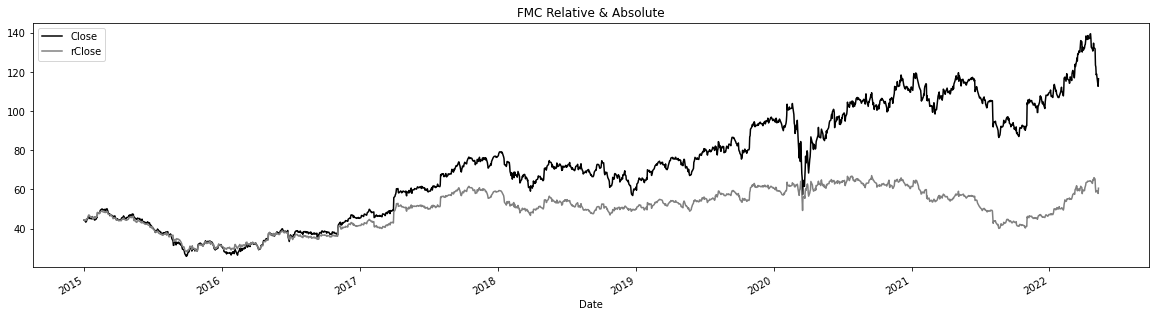

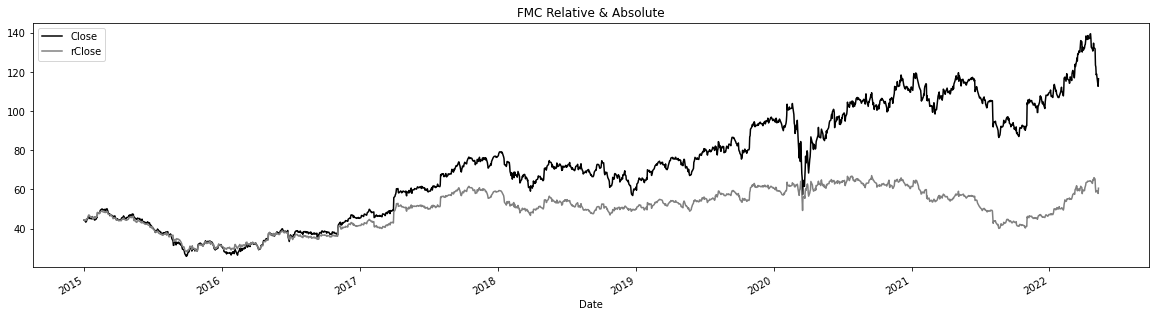

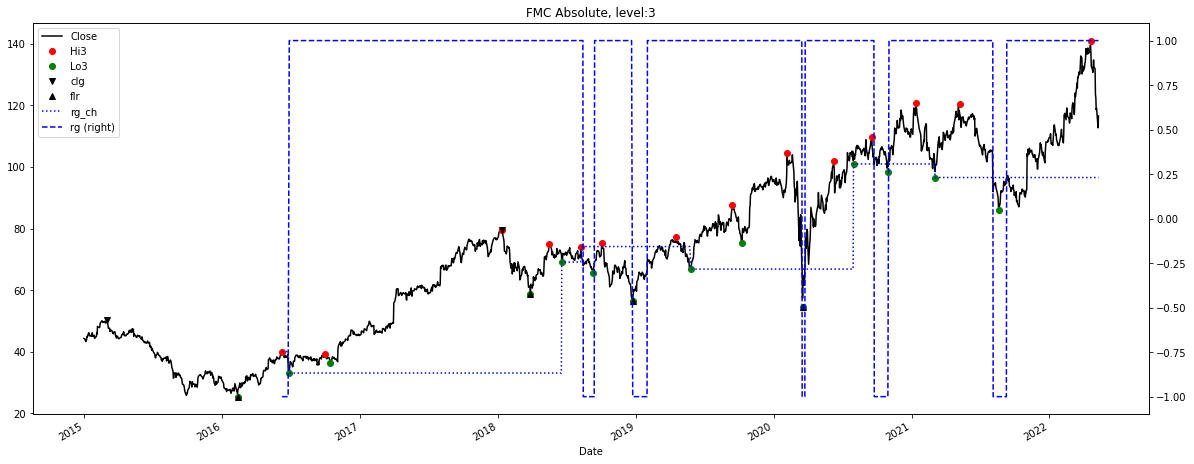

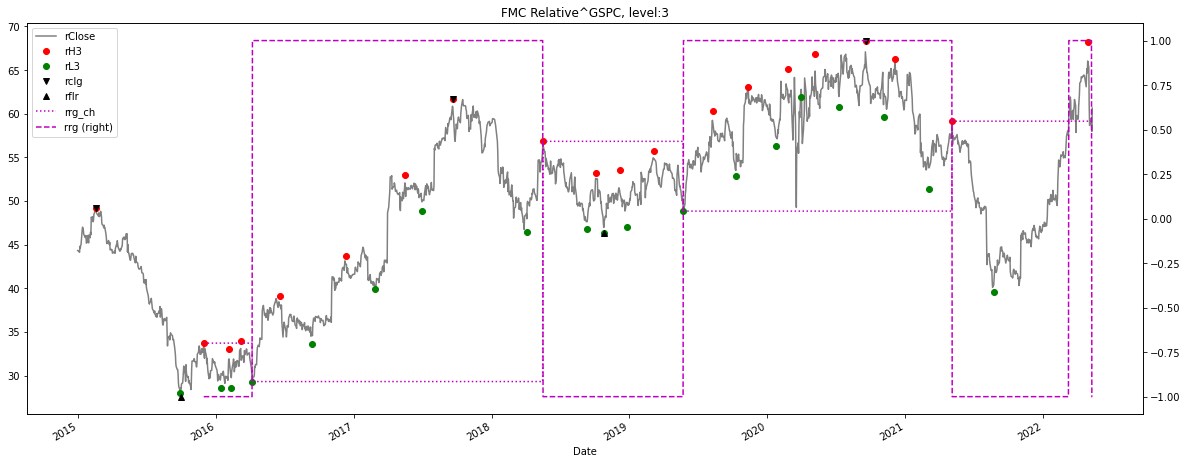

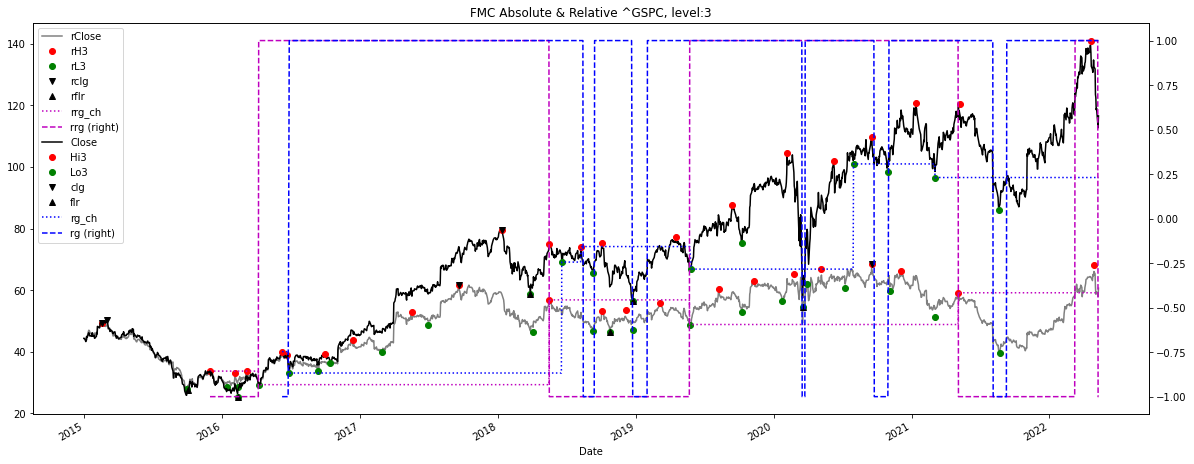

In [15]:
# CHAPTER 5: Regime Definition 
ticker = 'FMC'
lvl = 3 # Try different levels to see

df = round(yf.download(tickers= ticker,start= start, end = end,interval = "1d",
                 group_by = 'column',auto_adjust = True, prepost = True, 
                 treads = True, proxy = None),dgt)

df = swings(df,rel = False)
df = regime(df,lvl=3,rel = False)
df = swings(df,rel = True)
df = regime(df,lvl=3,rel= True)
_o,_h,_l,_c = lower_upper_OHLC(df,relative = False)

for a in range(2):    
    df['sma'+str(_c)[:1]+str(st)+str(lt)] = regime_sma(df,_c,st,lt)
    df['bo'+str(_h)[:1]+str(_l)[:1]+ str(slow)] = regime_breakout(df,_h,_l,window)
    df['tt'+str(_h)[:1]+str(fast)+str(_l)[:1]+ str(slow)] = turtle_trader(df, _h, _l, slow, fast)
    _o,_h,_l,_c = lower_upper_OHLC(df,relative = True)
    df[['Close','rClose']].plot(figsize=(20,5),style=['k','grey'],title = str.upper(ticker)+ ' Relative & Absolute')

plot_abs_cols = ['Close','Hi'+str(lvl), 'Lo'+str(lvl),'clg','flr','rg_ch','rg']
plot_abs_style = ['k', 'ro', 'go', 'kv', 'k^','b:','b--']
y2_abs = ['rg']
plot_rel_cols = ['rClose','rH'+str(lvl), 'rL'+str(lvl),'rclg','rflr','rrg_ch','rrg']
plot_rel_style = ['grey', 'ro', 'go', 'kv', 'k^','m:','m--']
y2_rel = ['rrg']
df[plot_abs_cols].plot(secondary_y= y2_abs,figsize=(20,8),
            title = str.upper(ticker)+ ' Absolute, level:'+str(lvl),# grid=True,
            style=plot_abs_style)

df[plot_rel_cols].plot(secondary_y=y2_rel,figsize=(20,8),# grid=True,
            title = str.upper(ticker)+ ' Relative'+str.upper(bm_ticker)+', level:'+str(lvl),
            style=plot_rel_style)

df[plot_rel_cols + plot_abs_cols].plot(secondary_y=y2_rel + y2_abs,figsize=(20,8),# grid=True,
            title = str.upper(ticker)+ ' Absolute & Relative '+str.upper(bm_ticker)+', level:'+str(lvl),
            style=plot_rel_style + plot_abs_style)

### Regime combo visualisation
This final block of code plots the data in a more visually appealing way

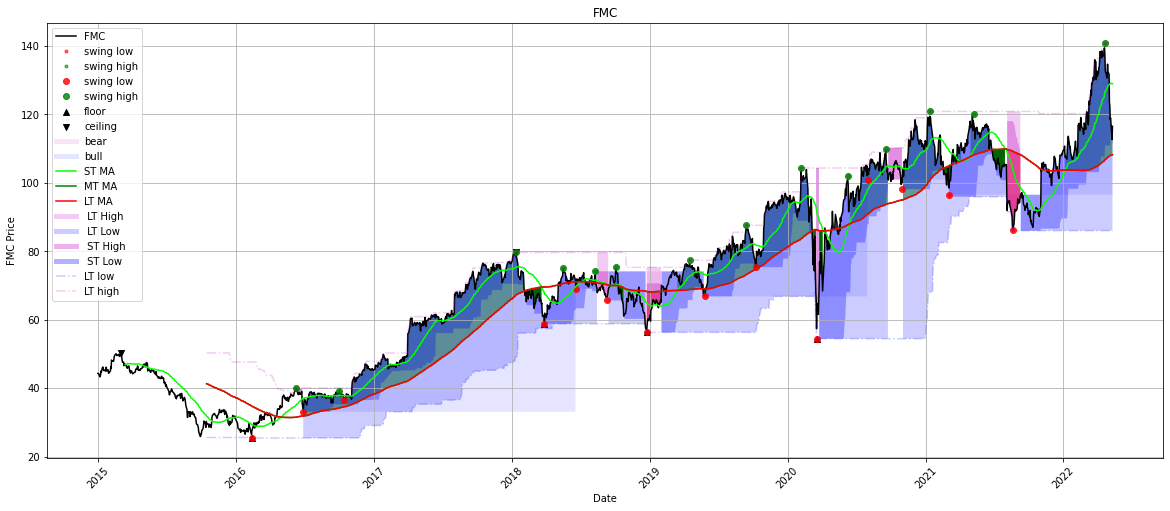

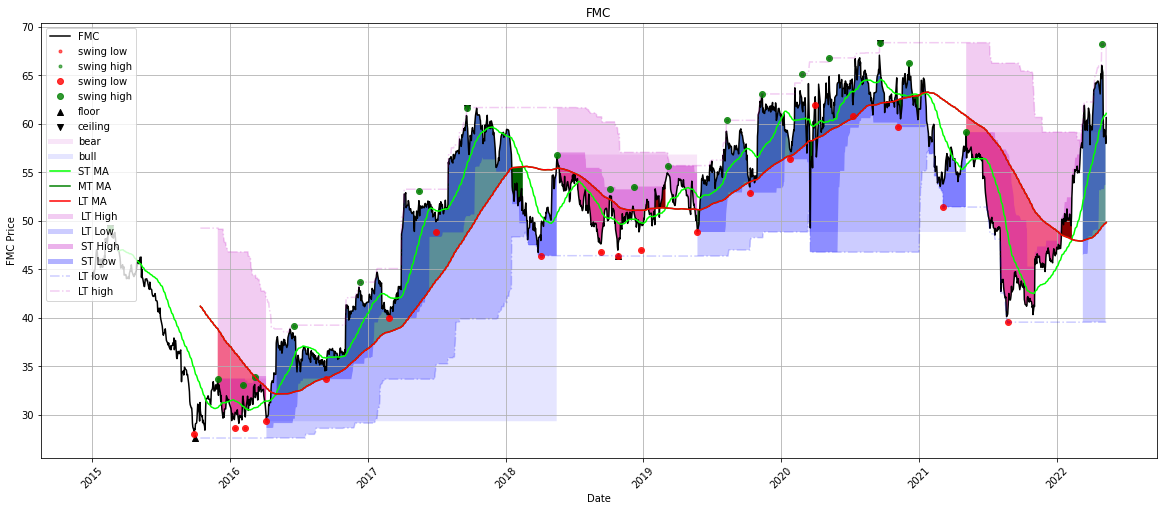

In [16]:
# CHAPTER 5: Regime Definition 
mav = [fast, slow, 200]
bo = [fast, slow]
# ma_st = ma_mt = ma_lt = lt_lo = lt_hi = st_lo = st_hi = 0

_o,_h,_l,_c = lower_upper_OHLC(df,relative = False)
ma_st,ma_mt,ma_lt = [df[_c].rolling(mav[t]).mean() for t in range(len(mav))]
st_lo,lt_lo = [df[_l].rolling(bo[t]).min() for t in range(len(bo))]
st_hi,lt_hi = [df[_h].rolling(bo[t]).max() for t in range(len(bo))]

rg_combo = ['Close','rg','Lo'+str(lvl),'Hi'+str(lvl),'Lo'+str(lvl),'Hi'+str(lvl),'clg','flr','rg_ch']
_c,rg,lo,hi,slo,shi,clg,flr,rg_ch =[rg_combo[r] for r in range(len(rg_combo)) ]
graph_regime_combo(ticker,df,_c,rg,lo,hi,slo,shi,clg,flr,rg_ch,ma_st,ma_mt,ma_lt,lt_lo,lt_hi,st_lo,st_hi)

_o,_h,_l,_c = lower_upper_OHLC(df,relative = True)
ma_st,ma_mt,ma_lt = [df[_c].rolling(mav[t]).mean() for t in range(len(mav))]
st_lo,lt_lo = [df[_l].rolling(bo[t]).min() for t in range(len(bo))]
st_hi,lt_hi = [df[_h].rolling(bo[t]).max() for t in range(len(bo))]

rrg_combo = ['rClose','rrg','rL'+str(lvl),'rH'+str(lvl),'rL'+str(lvl),'rH'+str(lvl),'rclg','rflr','rrg_ch']
_c,rg,lo,hi,slo,shi,clg,flr,rg_ch =[rrg_combo[r] for r in range(len(rrg_combo)) ]
graph_regime_combo(ticker,df,_c,rg,lo,hi,slo,shi,clg,flr,rg_ch,ma_st,ma_mt,ma_lt,lt_lo,lt_hi,st_lo,st_hi)